In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [5]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

import matplotlib.pyplot as plt
import cv2
from PIL import Image

import glob

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [15]:
import sys
sys.path.append('../')
sys.path.append('../core')

from raft import RAFT
from train import get_args, load_model
import datasets as raft_datasets
import utils.flow_viz as flow_viz
import utils.segs_viz as segs_viz

def set_args(args_dict={}):
    args = get_args("")
    for k,v in args_dict.items():
        args.__setattr__(k, v)
    return args
    
def downsample_affinities(affs, size, downsample_factor=2):
    affs = affs.view(1, size[0]*size[1], size[0], size[1])
    ds = downsample_factor
    N = size[0]*size[1]
    N_out = N // (ds**2)
    affs = F.avg_pool2d(affs, kernel_size=[ds,ds], stride=ds)
    affs = affs.view(1,size[0],size[1],-1).permute(0,3,1,2)
    affs = F.avg_pool2d(affs, kernel_size=[ds,ds], stride=ds)
    affs = affs.view(1,N_out,N_out).transpose(1,2)
    return affs    
    

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Load some TDW preds and gt

In [7]:
results_path = '/mnt/fs6/honglinc/eccv_2022_results/TDW_128_RAFT_sintel0.5_b8'
results = sorted(os.listdir(results_path))

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [14]:
ex = 0
data = torch.load(results_path + '/' + results[ex])
for k,v in data.items():
    if isinstance(v, torch.Tensor):
        print(k, v.shape, v.dtype)
    else:
        print(k, "list len %d" % len(v), v[0].shape, v[0].dtype)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


image torch.Size([3, 512, 512]) torch.uint8
affinities torch.Size([1, 16384, 16384]) torch.float32
pred_segments list len 4 (512, 512) bool
gt_segments list len 4 (512, 512) bool


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


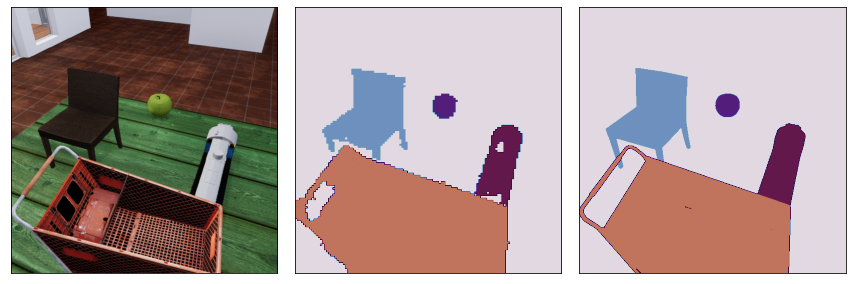

In [55]:
segs_viz.plot_image_pred_gt_segments(data, figsize=(12,4), cmap='twilight',
                                     save_path='/home/dbear/tdw_image_pred_gt.svg')